# DS3000 Final Project Notebook - Group 15

Contributors:
- Kwaku Asare
- Tejanvesh Gangavarapu
- Obaid Mohiuddin
- Zain Syed

## Important Note
The dataset we chose for this project comes with a predefined test set, and a predefined training set. Unfortunately the test set is not valuable to us as it does not allow for us to do data Validation. This is because it does not include the Stay feature. After some research, we discovered this is usually meant to generate predictions for the sake of uploading them to kaggle.

The best option now is to use the train dataset for training, and validation on top of that. That is why we have not implemented the test dataset for the time being. When we are satisfied with the results, we can submit our predictions to Kaggle, to get graded.

In [1]:
! pip install kagglehub
! pip install pandas matplotlib seaborn scikit-learn
! pip install catboost
! pip install lightgbm
! pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl (115.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 2.0 MB/s eta 0:00:00m eta 0:00:010:00:03


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import lightgbm as lgb
import xgboost as xgb

## Part 1 (Phase II): Data Parsing, Management, & Analysis

- Loading Dataset from the train_data.csv file
    - Printing out basic data (The first 5 rows, and column information)
- Map *Stay* parameter to a positive integer, and one-hot encode categorical features
- Plotting Distribution of all features in the Dataset
- Create Correlation Matricies (one with, and one without categorical columns)
- Train a sample Random Forest model to observe importance scores of different features

In [2]:
sample_sub = pd.read_csv("sample_sub.csv")
df = pd.read_csv("train_data.csv")
train_data_dictionary = pd.read_csv("train_data_dictionary.csv")

#print("Sample")
#print(sample_sub.head())
#print(sample_sub.info())
#print("\n")

print("Train Data")
print(df.head())
print(df.info())
print("\n")

print("Train Data Dictionary")
print(train_data_dictionary)
print("\n")

Train Data
   case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0        1              8                  c                   3   
1        2              2                  c                   5   
2        3             10                  e                   1   
3        4             26                  b                   2   
4        5             26                  b                   2   

  Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                    Z                                  3  radiotherapy   
1                    Z                                  2  radiotherapy   
2                    X                                  2    anesthesia   
3                    Y                                  2  radiotherapy   
4                    Y                                  2  radiotherapy   

  Ward_Type Ward_Facility_Code  Bed Grade  patientid  City_Code_Patient  \
0         R                  F        2.0      31397  

In [3]:
# We have created a mapping, to allow us to turn our Value numeric, without 
if not pd.api.types.is_numeric_dtype(df["Stay"]):
    stay_mapping = {
        "0-10": 0,
        "11-20": 1,
        "21-30": 2,
        "31-40": 3,
        "41-50": 4,
        "51-60": 5,
        "61-70": 6,
        "71-80": 7,
        "81-90": 8,
        "91-100": 9,
        "More than 100 Days": 10
    }
    
    df["Stay"] = df["Stay"].map(stay_mapping)
print(df["Stay"].head())

0    0
1    4
2    3
3    4
4    4
Name: Stay, dtype: int64


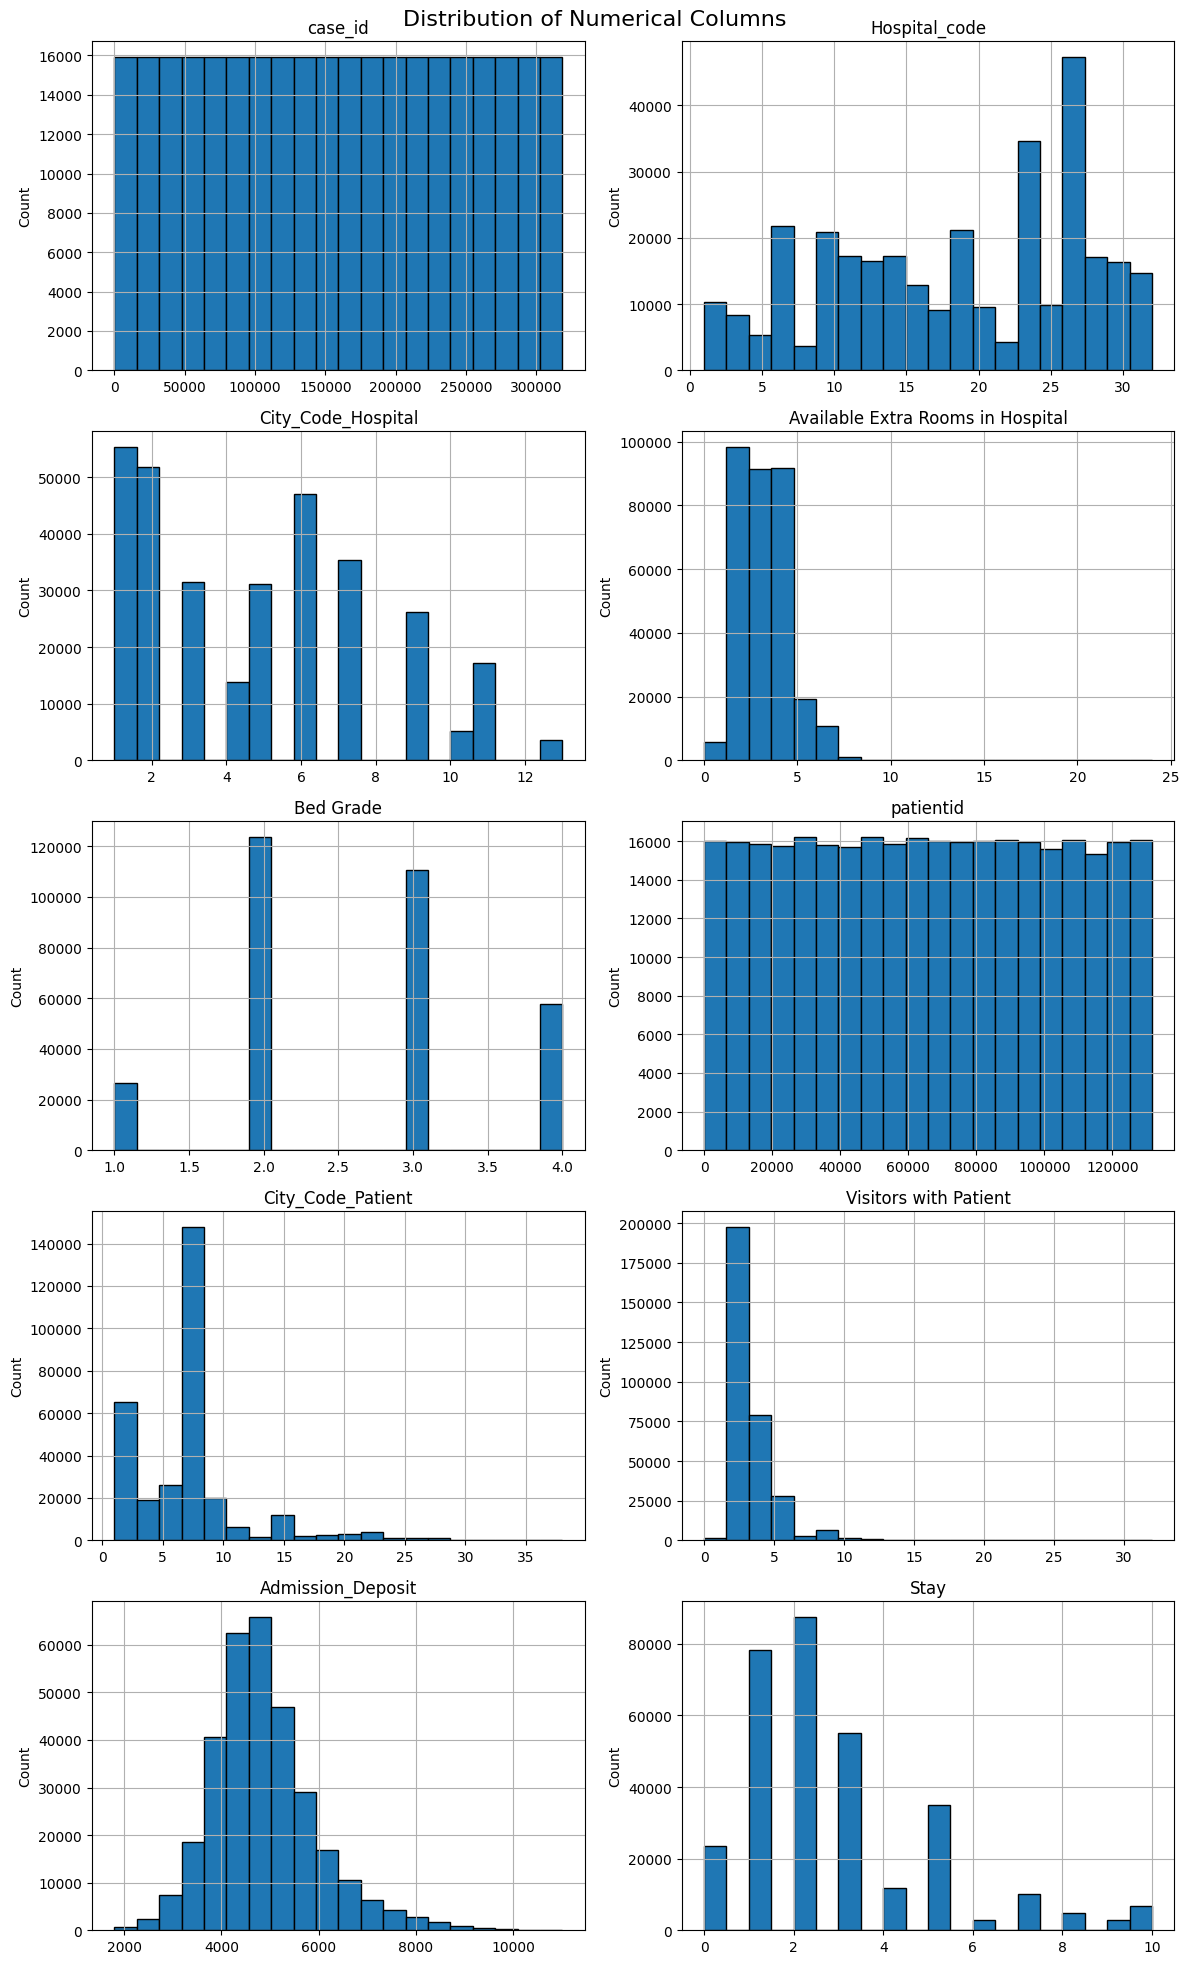

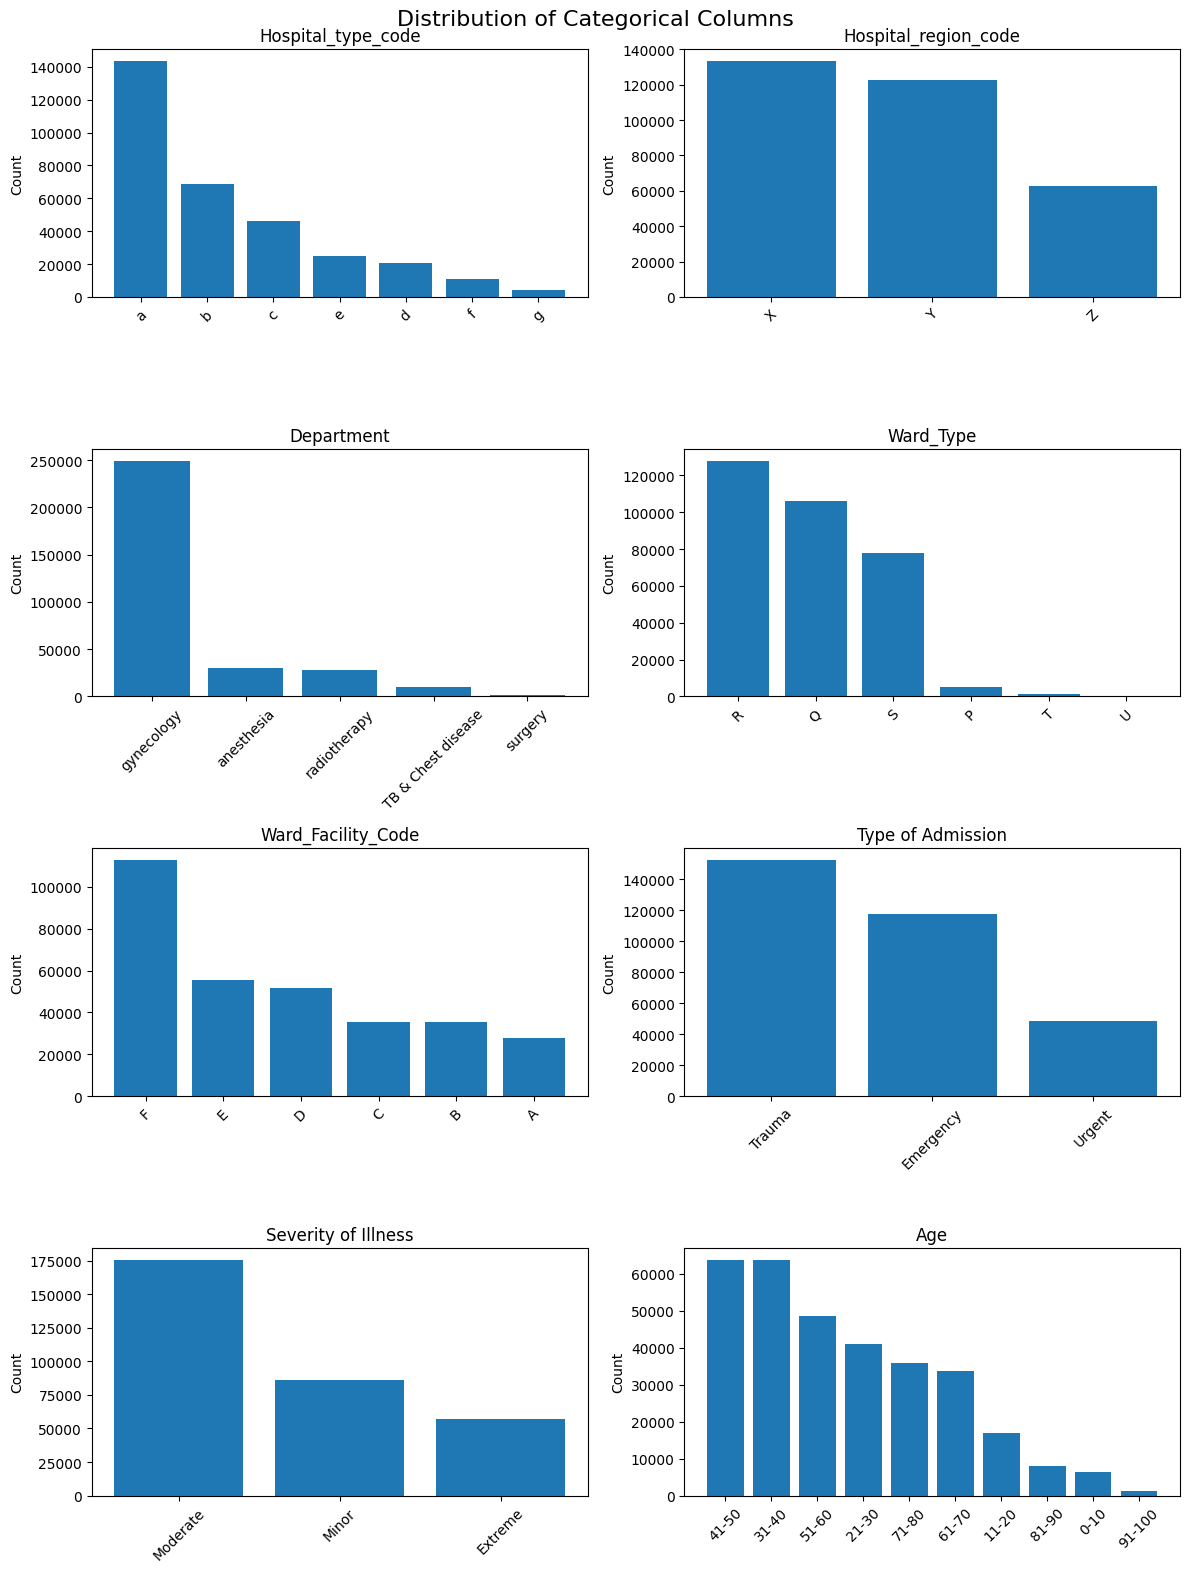

In [4]:
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist() # Selects all numerical columns
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist() # Selects all categorical columns (non-integers/objects)

n_cat = len(categorical_cols)
n_num = len(numerical_cols)
n_cols = 2 
n_cat_rows = math.ceil(n_cat / n_cols)
n_num_rows = math.ceil(n_num / n_cols)


fig, axes = plt.subplots(n_num_rows, n_cols, figsize=(6 * n_cols, 4 * n_num_rows))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]
    df[col].hist(bins=20, ax=ax, edgecolor="black")
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("Count")

for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("Distribution of Numerical Columns", fontsize=16)
plt.tight_layout()
plt.show()




fig = plt.figure(figsize=(6 * n_cols, 4 * n_cat_rows))

for idx, col in enumerate(categorical_cols, start=1):
    ax = fig.add_subplot(n_cat_rows, n_cols, idx)
    vc = df[col].value_counts().sort_values(ascending=False)

    ax.bar(vc.index.astype(str), vc.values)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)

fig.suptitle("Distribution of Categorical Columns", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
dfe = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

print(dfe.info())

# Different from variable numerical_columns since that one stores a list
numeric_cols = df.select_dtypes(include=["int64", "float64"])
corr_matrix = dfe.corr()
num_corr_matrix = numeric_cols.corr()

print(corr_matrix["Stay"].sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 53 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   City_Code_Hospital                 318438 non-null  int64  
 3   Available Extra Rooms in Hospital  318438 non-null  int64  
 4   Bed Grade                          318325 non-null  float64
 5   patientid                          318438 non-null  int64  
 6   City_Code_Patient                  313906 non-null  float64
 7   Visitors with Patient              318438 non-null  int64  
 8   Admission_Deposit                  318438 non-null  float64
 9   Stay                               318438 non-null  int64  
 10  Hospital_type_code_a               318438 non-null  bool   
 11  Hospital_type_code_b               3184

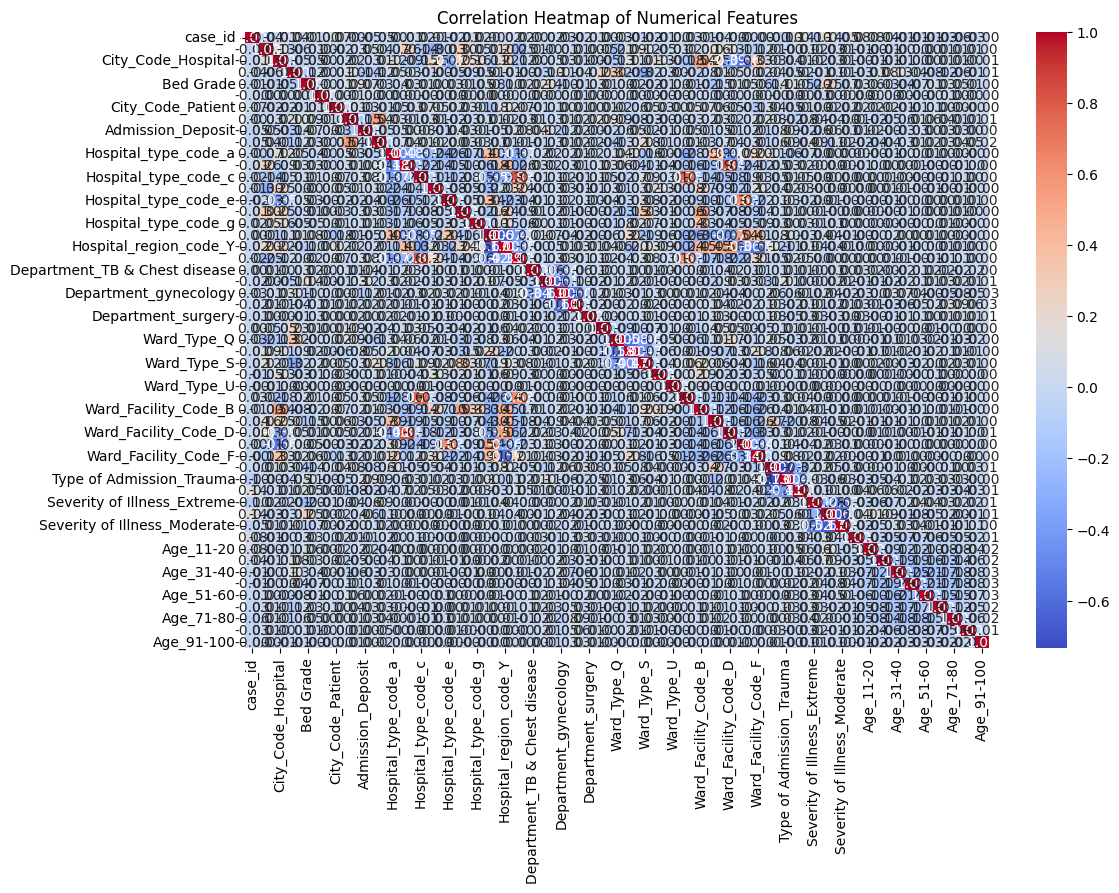

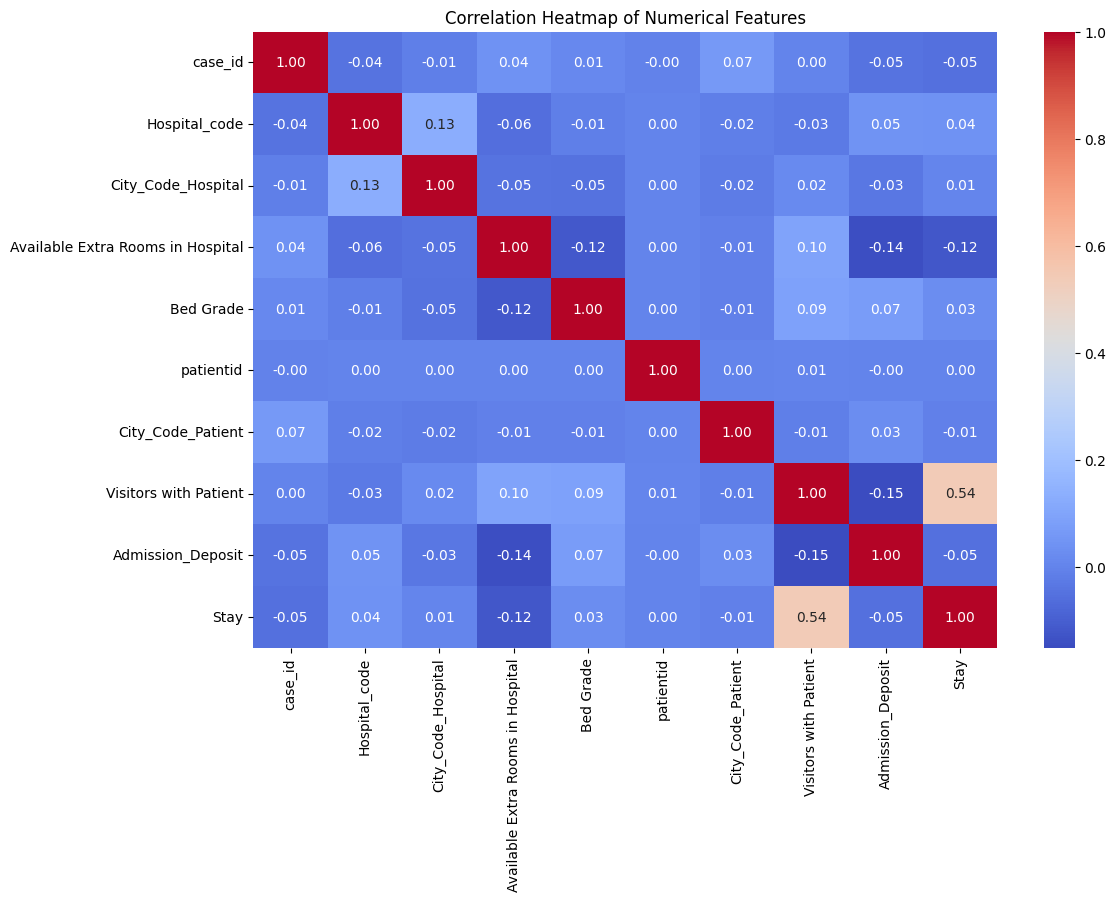

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(num_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

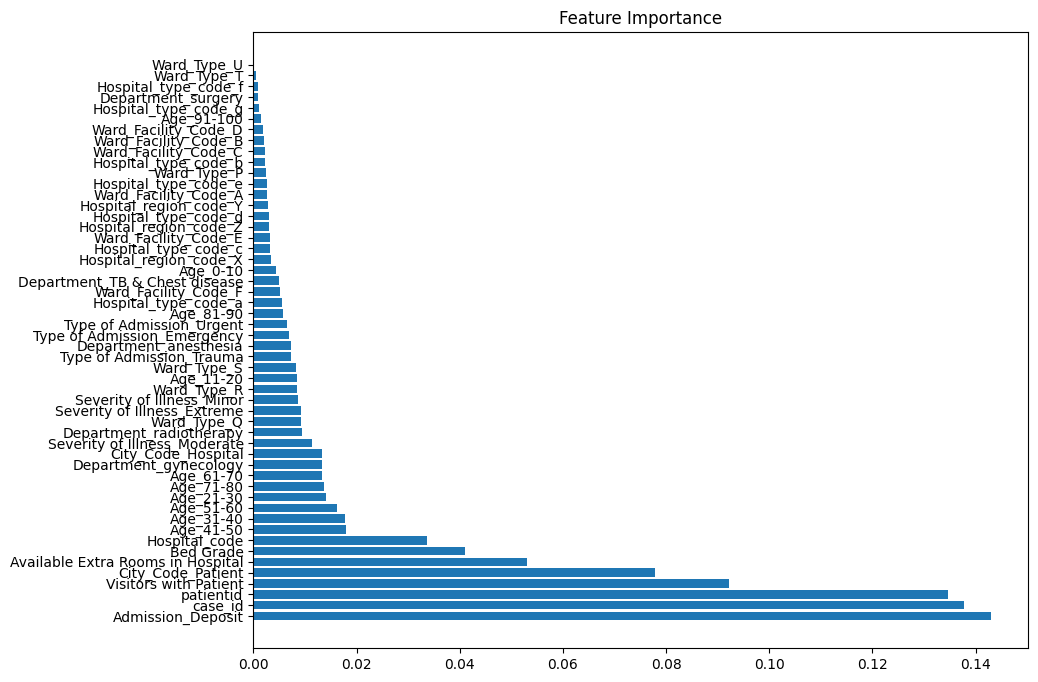

In [10]:
X = dfe.drop("Stay", axis = 1)
y = dfe["Stay"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = importances.argsort()

plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.gca().invert_yaxis()  # Top feature at the top
plt.show()

In [11]:
print("Feature Ranking (By Importance")
for i in range(X_train.shape[1]):
    print(f"{i + 1}. Feature: {X_train.columns[indices[i]]}, Importance: {importances[indices[i]]}")

Feature Ranking (By Importance
1. Feature: Ward_Type_U, Importance: 6.994681610659935e-06
2. Feature: Ward_Type_T, Importance: 0.0005888558554906972
3. Feature: Hospital_type_code_f, Importance: 0.0008177770671176368
4. Feature: Department_surgery, Importance: 0.0008879342319281984
5. Feature: Hospital_type_code_g, Importance: 0.0009992539430198598
6. Feature: Age_91-100, Importance: 0.001395124917243054
7. Feature: Ward_Facility_Code_D, Importance: 0.001793929622842216
8. Feature: Ward_Facility_Code_B, Importance: 0.002153132432262022
9. Feature: Ward_Facility_Code_C, Importance: 0.0022281279253491453
10. Feature: Hospital_type_code_b, Importance: 0.002342654121308519
11. Feature: Ward_Type_P, Importance: 0.0025316491420360556
12. Feature: Hospital_type_code_e, Importance: 0.002556395648140242
13. Feature: Ward_Facility_Code_A, Importance: 0.002643320228931158
14. Feature: Hospital_region_code_Y, Importance: 0.0027638557783339224
15. Feature: Hospital_type_code_d, Importance: 0.003036

## Part 2) Feature Selection

Our dataset contains many features that either have low correlation with the target, minimal importance in a Random Forest context, or pose clear risks for overfitting, so careful feature selection is necessary before model training. Initial analysis showed that only one feature has moderate correlation with the target and overall linear relationships are weak, meaning linear models are unlikely to perform well. Random Forest importance scores suggest a small subset of features meaningfully contributes to prediction, while ID-type columns and other unrelated attributes should be removed entirely. Our plan is to prioritize feature removal based on low importance rather than correlation, then build a refined feature set that supports non-linear models. Once feature selection is complete, we will use Logistic Regression as a baseline and then train and evaluate more suitable models like Random Forest, XGBoost, or LightGBM.

Firstly, it is in our best interest to remove blatantly irrelevant features, the first that comes to mind is anything that is an ID (even if it has high importance, there is no correlation between id and Stay.

On top of that, with similar logic, we can remove features such as City_Code_Patient, City_Code_Hospital, and Hospital_Code

It also can be quite helpful to remove features with Low Importance (with respect to RF), and low correlation (in a linear fashion), **espescially when they are bad in BOTH scenarios**. This usually means the data isn't really helpful, and we can safely remove it. Features that have proven to be bad in both scenarios are: 
- Ward_Type_U
- Ward_Type_T
- Hospital_type_code_f
- Hospital_type_code_g
- Hospital_region_code_X
- Hospital_region_code_Y
- Hospital_region_code_Z
- Department_surgery
- Department_radiotherapy
- Department_gynecology
- Department_anesthesia
- Department_TB & Chest disease

Some interesting things to note: Ward Types U and T are in a LARGE MINORITY compared to the other Ward Types, which is likely why they are useless features compared to the others. The same applies to Hosptial Type Codes f and g.

Hospital Region Codes as a whole seem to be quite useless, as they haven't given us much to work with, so we remove all 3.

The Department Types are incredibly unbalanced, with an overwhelming majority going towards gynecology, we simply do not see a benefit in keeping any of them, due to their low importance, low correlation, and gigantic imbalance throughout.

We start by removing these, which gives us a good minimized list of features to test with before removing any more.

In [16]:
# Printing Base RF Model Accuracy for Comparison Purposes
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.41051689486245446


In [6]:
# Dropping the 2 ID features
dfe = dfe.drop(['case_id', 'patientid'], axis=1)

# Dropping the 3 "code" features
dfe = dfe.drop(['City_Code_Patient', 'City_Code_Hospital', 'Hospital_code'], axis=1)

# Dropping the remaning "low performers"
dfe = dfe.drop([
    'Ward_Type_U',
    'Ward_Type_T',
    'Hospital_type_code_f',
    'Hospital_type_code_g',
    'Hospital_region_code_X',
    'Hospital_region_code_Y',
    'Hospital_region_code_Z',
    'Department_surgery',
    'Department_radiotherapy',
    'Department_gynecology',
    'Department_anesthesia',
    'Department_TB & Chest disease'
], axis=1)

print(dfe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 36 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  318438 non-null  int64  
 1   Bed Grade                          318325 non-null  float64
 2   Visitors with Patient              318438 non-null  int64  
 3   Admission_Deposit                  318438 non-null  float64
 4   Stay                               318438 non-null  int64  
 5   Hospital_type_code_a               318438 non-null  bool   
 6   Hospital_type_code_b               318438 non-null  bool   
 7   Hospital_type_code_c               318438 non-null  bool   
 8   Hospital_type_code_d               318438 non-null  bool   
 9   Hospital_type_code_e               318438 non-null  bool   
 10  Ward_Type_P                        318438 non-null  bool   
 11  Ward_Type_Q                        3184

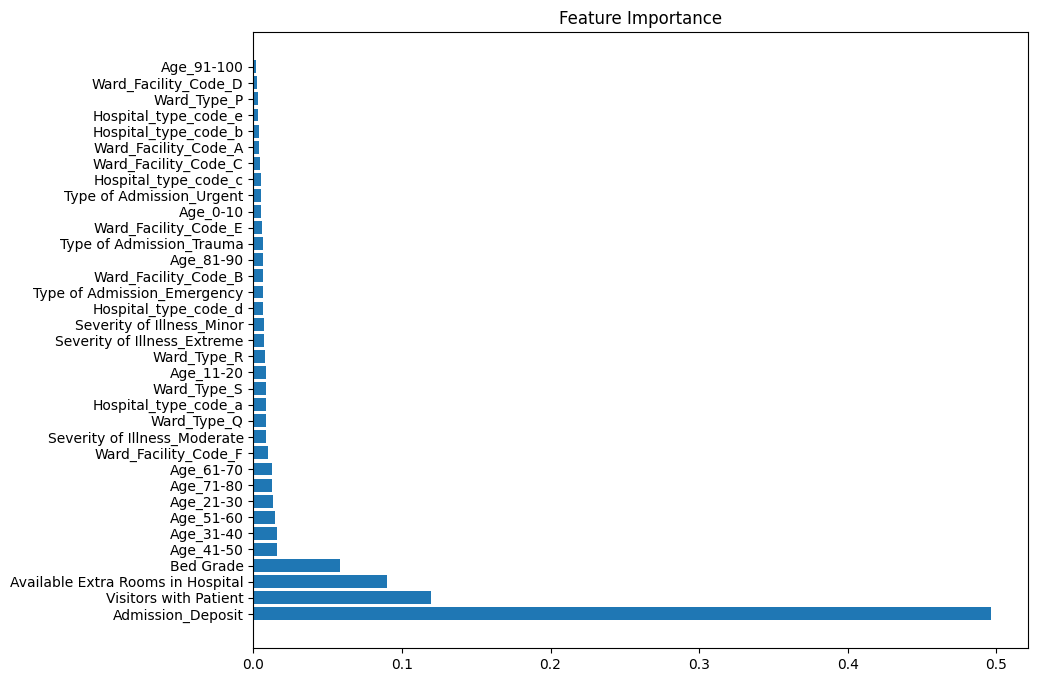

Feature Ranking (By Importance
1. Feature: Age_91-100, Importance: 0.002015493496399853
2. Feature: Ward_Facility_Code_D, Importance: 0.002718738022719834
3. Feature: Ward_Type_P, Importance: 0.002907849423950241
4. Feature: Hospital_type_code_e, Importance: 0.0032005285315395084
5. Feature: Hospital_type_code_b, Importance: 0.0037196129675171156
6. Feature: Ward_Facility_Code_A, Importance: 0.0038324807813432797
7. Feature: Ward_Facility_Code_C, Importance: 0.004517080450210094
8. Feature: Hospital_type_code_c, Importance: 0.005299497301787068
9. Feature: Type of Admission_Urgent, Importance: 0.005377087024187203
10. Feature: Age_0-10, Importance: 0.0054180561683755905
11. Feature: Ward_Facility_Code_E, Importance: 0.006108918021367686
12. Feature: Type of Admission_Trauma, Importance: 0.00624214970637555
13. Feature: Age_81-90, Importance: 0.0062738020043986145
14. Feature: Ward_Facility_Code_B, Importance: 0.006327506686347854
15. Feature: Type of Admission_Emergency, Importance: 0.

In [7]:
X = dfe.drop("Stay", axis = 1)
y = dfe["Stay"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf2 = RandomForestClassifier()
rf2.fit(X_train, y_train)

importances = rf2.feature_importances_
indices = importances.argsort()

plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.gca().invert_yaxis()  # Top feature at the top
plt.show()

print("Feature Ranking (By Importance")
for i in range(X_train.shape[1]):
    print(f"{i + 1}. Feature: {X_train.columns[indices[i]]}, Importance: {importances[indices[i]]}")

In [8]:
y_pred = rf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3230435874890089


## Realization:

It is becoming clear that a RandomForest model is not the greatest option for this kind of dataset. This dataset seems to be noisy and filled with many less meaningful functions, as opposed to few valuable ones. 

We genuinely belive that One-Hot Encoding data with this many categorical features can be doing more harm than good, so we want to try something new.

Although a Tree-Based model would likely be our best bet for this kind of data, RandomForest may not be the best bet.

After some research, we found [CatBoost](https://www.datacamp.com/tutorial/catboost), a Gradient-Boosting model, which not only has a tree-structure, but also is good at handling categorical features, and complicated relationships betweem features and targets. Our best next step is to try training a base data set with this model, and seeing what we can do from there.

**SEE CatBoost.ipynb for information on that experiment** (And why this approach was not ideal)

## Next Steps:

We determined the hard way that CatBoost was not as great as we may have initially thought, and based on the written portion at the bottom of that file, we know that the dataset is not really going to be easy to work with for the following reasons:
- It is very noisy, and has a bunch of seemingly irrelevant data
- The features are almost all incredibly imbalanced
- **We have too many options for outputs for data this messy**

We think we can significantly help our chances of training a good model by working on that last point, while still staying true to our original purpose, of helping nurses and doctors easily determine the approximate *Stay* of patients.

The current plan is to reduce our Output Space, currently it is: 
- "0-10": 0,
- "11-20": 1,
- "21-30": 2,
- "31-40": 3,
- "41-50": 4,
- "51-60": 5,
- "61-70": 6,
- "71-80": 7,
- "81-90": 8,
- "91-100": 9,
- "More than 100 Days": 10

And below is the distribution of these features:

![img](stay.png)

A big realization we made is we don't need accuracy down to every 10 days. It would be helpful, but there is undoubtebly a good amount of information that Nurses, Doctors, & Hospitals can derive from more general time frames as well. **What if we cut it from 11 categories, down to 3, Short, Medium, and Long Term Stay**. We can define them with specified time slots, that not only make sense, but can also aim to balance that categorical features more.

We think a fair distrubution is:
- Short Term Stay: 0-20 days
- Medium Term Stay: 21-30 days
- Long Term Stay: 31+ Days
Not only is this a reasonable range, but it also divides the data up quite well in terms of all 3 features having similar distribution (Medium is still in the majority but it is not as bad as it was before).

We will explore this technique, as well as training on a model that is a little more lightweight than CatBoost, to see if we can get higher accuracy, with lower training time.

In [4]:
#Lets start with a fresh dataframe, since the previous iteration has a lot of changes
data = pd.read_csv("train_data.csv")
data = data.drop(["case_id", "patientid"], axis=1)
data2 = data.drop(["Department", "Hospital_region_code"], axis=1) # A second dataset dropping these 2 values as well, which we deemed irrelavant earlier

def stay_mapping(stay):
    # adjust these strings if your exact labels differ
    if stay in ["0-10", "11-20"]:
        return "short"          # 0–20 days
    elif stay in ["21-30"]:
        return "medium"         # 21–30 days
    else:
        # everything 31+ days, including "More than 100 Days"
        return "long"

data["Stay"] = data["Stay"].apply(stay_mapping)
data2["Stay"] = data["Stay"].apply(stay_mapping)

print(data["Stay"].value_counts()) # Prints a relatively even split (MUCH MUCH better than before) Short : Med : Long = 1.163 : 1 : 1.477

Stay
long      129204
short     101743
medium     87491
Name: count, dtype: int64


In [6]:
y = data["Stay"]
le = LabelEncoder()
y_enc = le.fit_transform(y)

X = data.drop(columns=["Stay"])

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

# Ordinal Encoder - Instead of splitting into multiple Boolean features, this maps features to integers, preserving the ordinal relationships between them
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_cat = oe.fit_transform(X[cat_cols])
X_num = X[num_cols].to_numpy()
X_all = np.concatenate([X_num, X_cat], axis=1)
cat_feature_indices = list(range(X_num.shape[1], X_all.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

In [38]:
train_dataset = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=cat_feature_indices,
    free_raw_data=False
)

valid_dataset = lgb.Dataset(
    X_test, label=y_test,
    categorical_feature=cat_feature_indices,
    free_raw_data=False
)

params = {
    "objective": "multiclass",
    "num_class": 3,
    "metric": "multi_logloss",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 1.0,
}

model = lgb.train(
    params,
    train_dataset,
    num_boost_round=500,
    valid_sets=[valid_dataset],
    valid_names=["valid"],
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 15
[LightGBM] [Info] Start training from score -0.902036
[LightGBM] [Info] Start training from score -1.291887
[LightGBM] [Info] Start training from score -1.140981
Training until validation scores don't improve for 50 rounds
[50]	valid's multi_logloss: 0.855037
[100]	valid's multi_logloss: 0.836641
[150]	valid's multi_logloss: 0.831292
[200]	valid's multi_logloss: 0.828737
[250]	valid's multi_logloss: 0.827455
[300]	valid's multi_logloss: 0.82639
[350]	valid's multi_logloss: 0.825602
[400]	valid's multi_logloss: 0.825106
[450]	valid's multi_logloss: 0.824738
[500]	valid's multi_logloss: 0.824422
Did not meet early stopping. Best iteration is

Accuracy: 0.606849013942972
              precision    recall  f1-score   support

        long       0.78      0.66      0.71     25841
      medium       0.47      0.48      0.47     17498
       short       0.55      0.66      0.60     20349

    accuracy                           0.61     63688
   macro avg       0.60      0.60      0.60     63688
weighted avg       0.62      0.61      0.61     63688

Number of boosting rounds:  500
Best score:  0.8244223960209722


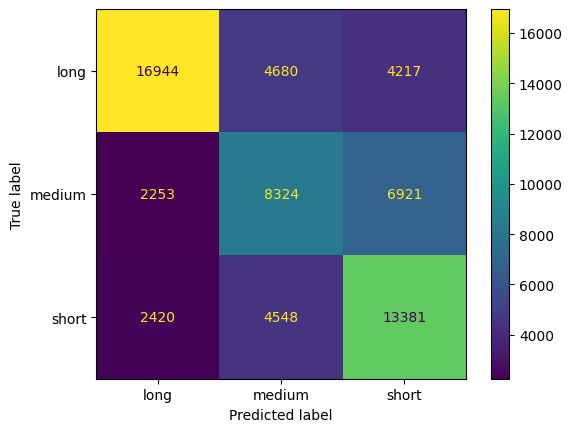

In [45]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
model1_conf = confusion_matrix(y_test, y_pred)
conf1_display = ConfusionMatrixDisplay(confusion_matrix = model1_conf, display_labels=['long','medium','short'])
conf1_display.plot()

print("Number of boosting rounds: ", model.best_iteration)
print("Best score: ", model.best_score['valid']['multi_logloss'])

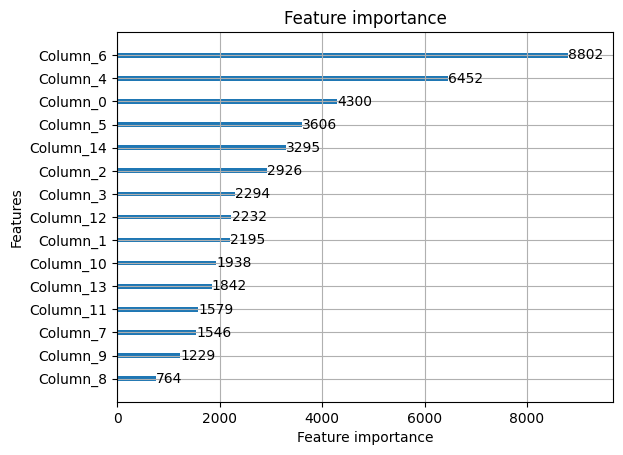

List of Features Ranked By Importance:
                              Feature  Importance
6                           Ward_Type        8802
4   Available Extra Rooms in Hospital        6452
0                       Hospital_code        4300
5                          Department        3606
14                  Admission_Deposit        3295
2                  City_Code_Hospital        2926
3                Hospital_region_code        2294
12              Visitors with Patient        2232
1                  Hospital_type_code        2195
10                  Type of Admission        1938
13                                Age        1842
11                Severity of Illness        1579
7                  Ward_Facility_Code        1546
9                   City_Code_Patient        1229
8                           Bed Grade         764


In [41]:
# Plotting Importance Scores from the Model
lgb.plot_importance(model)
plt.show()

# Printing out importance scores with the original feature name (instead of Column N)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("List of Features Ranked By Importance:")
print(importance_df)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 12
[LightGBM] [Info] Start training from score -0.902036
[LightGBM] [Info] Start training from score -1.291887
[LightGBM] [Info] Start training from score -1.140981
Training until validation scores don't improve for 50 rounds
[50]	valid's multi_logloss: 0.84692
[100]	valid's multi_logloss: 0.832405
[150]	valid's multi_logloss: 0.829237
[200]	valid's multi_logloss: 0.827827
[250]	valid's multi_logloss: 0.827139
[300]	valid's multi_logloss: 0.826774
[350]	valid's multi_logloss: 0.826519
[400]	valid's multi_logloss: 0.826249
[450]	valid's multi_logloss: 0.826138
[500]	valid's multi_logloss: 0.826098
Did not meet early stopping. Best iteration is

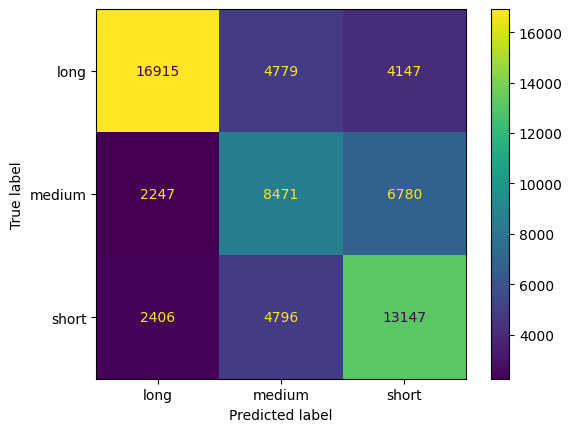

In [46]:
# Training one more model WITH SAME PARAMAETERS after dropping some less important features:

X_all_dropped = X_all[:, ~np.isin(X.columns, ['Bed Grade', 'City_Code_Patient', 'Ward_Facility_Code'])]
X_train_dropped = X_train[:, ~np.isin(X.columns, ['Bed Grade', 'City_Code_Patient', 'Ward_Facility_Code'])]
X_test_dropped = X_test[:, ~np.isin(X.columns, ['Bed Grade', 'City_Code_Patient', 'Ward_Facility_Code'])]

train_dataset_dropped = lgb.Dataset(
    X_train_dropped, label=y_train,
    categorical_feature=cat_feature_indices,
    free_raw_data=False
)

valid_dataset_dropped = lgb.Dataset(
    X_test_dropped, label=y_test,
    categorical_feature=cat_feature_indices,
    free_raw_data=False
)

params = {
    "objective": "multiclass",
    "num_class": 3,
    "metric": "multi_logloss",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 1.0,
}


model2 = lgb.train(
    params,
    train_dataset_dropped,
    num_boost_round=500,
    valid_sets=[valid_dataset_dropped],
    valid_names=["valid"],
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

y_pred_proba = model2.predict(X_test_dropped)
y_pred = y_pred_proba.argmax(axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
model2_conf = confusion_matrix(y_test, y_pred)
conf2_display = ConfusionMatrixDisplay(confusion_matrix = model2_conf, display_labels=['long','medium','short'])
conf2_display.plot()

## Comparison between model with and without removed features:

As explained througout the code above, we started with fresh data, after removing case_id and patientid (of course). We then trained an LightGBM model off of this data, which yielded us our greatest accuracy yet, at approximately 60.68%.

After that, we plotted the importance scores, and removed the 3 least important features (being Ward_Facility_Code, City_Code_Patient, & Bed Grade). We then trained off this dataset, and got an accuracy of: 60.5%

The 2 models show almost no difference between eachother when trained on the same dataset, and interestingly enough, the 2nd model is ever so slightly worse than the first, which seems a bit counter-intuitive.


\
**Model 1 (All Features):**

![img](1.png)


\
**Model 2 (Removed Features):**

![img](2.png)

\
Regardless, it is clear that switching to the more general 3 categories, as opposed to a target value with **12**, was an excellent idea. LightGBM also seems to have done a good job as well, which makes sense, since it was specifically designed to work with more compelx models, being a far more advanced, gradient-boosting, Tree Model. Its innovations in feature handling, and optimization are likely why it did so well.

### Next Steps:

The final portion of this project is to test one final type of model to see if we can gain better accuracy, and performance metrics for this ridiculously messy dataset! Although CatBoost may have been a good option, we do not have the computational power to work it out. Instead we will try using XGBoost, which is a final potential contendor which really may make this dataset work well. If it yields better results than its predecessors, then we will stick with it into the final stage of the project, otherwise we will use LightGBM.

Once a final model is decided, we will go through some fine-tuning to see if we can improve our model to it's best potential!

In [8]:
# Create Train/Test set with previously defined variables:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

# XGBoost prefers DMatrix data, so we perform a conversion
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    "objective": "multi:softmax",    
    "num_class": 3,                  
    "eval_metric": "merror",         
    "learning_rate": 0.05,           
    "max_depth": 10,                
    "num_leaves": 64,              
    "lambda": 1.0,                 
    "alpha": 0.1,                 
    "subsample": 0.8,                # Randomly samples rows
    "colsample_bytree": 0.8,         # Randomly samples columns
    "scale_pos_weight": 1.0,         # XGBoost has this parameter to help us tackle class imbalances in features
}

In [9]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,  
    early_stopping_rounds=50,
    evals=[(dtest, 'eval')],  
)

[0]	eval-merror:0.59350
[1]	eval-merror:0.56526
[2]	eval-merror:0.50818
[3]	eval-merror:0.46726
[4]	eval-merror:0.45550
[5]	eval-merror:0.44033
[6]	eval-merror:0.42846
[7]	eval-merror:0.42413
[8]	eval-merror:0.41926
[9]	eval-merror:0.41722
[10]	eval-merror:0.41345
[11]	eval-merror:0.41017
[12]	eval-merror:0.40871
[13]	eval-merror:0.40736
[14]	eval-merror:0.40535
[15]	eval-merror:0.40468
[16]	eval-merror:0.40486
[17]	eval-merror:0.40386
[18]	eval-merror:0.40353
[19]	eval-merror:0.40361
[20]	eval-merror:0.40359
[21]	eval-merror:0.40334
[22]	eval-merror:0.40267
[23]	eval-merror:0.40209
[24]	eval-merror:0.40152
[25]	eval-merror:0.40077
[26]	eval-merror:0.40125
[27]	eval-merror:0.40084
[28]	eval-merror:0.40042
[29]	eval-merror:0.40036
[30]	eval-merror:0.40037
[31]	eval-merror:0.40000
[32]	eval-merror:0.39976
[33]	eval-merror:0.39959
[34]	eval-merror:0.39951
[35]	eval-merror:0.39909
[36]	eval-merror:0.39913
[37]	eval-merror:0.39876
[38]	eval-merror:0.39882
[39]	eval-merror:0.39869
[40]	eval-

Accuracy: 0.6076968973747017
Classification Report:
              precision    recall  f1-score   support

        long       0.78      0.67      0.72     25841
      medium       0.47      0.48      0.48     17498
       short       0.55      0.64      0.59     20349

    accuracy                           0.61     63688
   macro avg       0.60      0.60      0.60     63688
weighted avg       0.62      0.61      0.61     63688



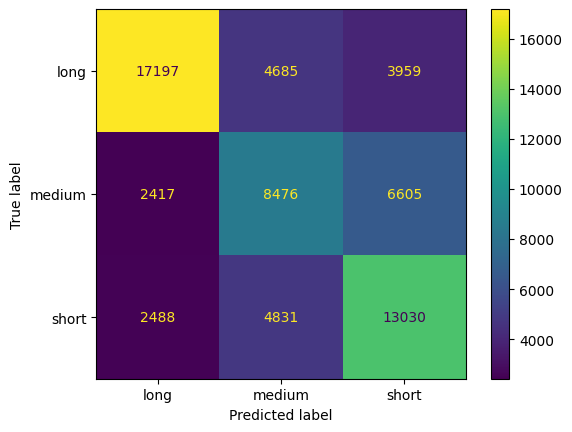

In [11]:
y_pred = model.predict(dtest)
y_pred = np.round(y_pred).astype(int)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
model3_conf = confusion_matrix(y_test, y_pred)
conf3_display = ConfusionMatrixDisplay(confusion_matrix = model3_conf, display_labels=['long','medium','short'])
conf3_display.plot()

# model.save_model('xgboost_model.json')

### Fine Tuning Register:

**For obvious reasons, I will not be leaving all the code and all the outputs for model training, so instead the following block will be reused/adjusted, and I will do 5 iterations of training with different parameters. All iterations will be documented below, and we will select the best as our "final" model**

After some comparisons, we are going to commit to XGBoost. Although it didn't perform that much better than LightGBM(60.68%), we did get slightly higher, at 60.77%, with a decently better correlation matrix, and slightly better Classification Report as well. This is our best model by far.

I also am going to assume removing non-important features has a negligible effect on the model itself, as we saw in the LightGBM, so I will assume it does so here as well and proceed with the dataset with all features (excluding the IDs of course)

---

1 (Base Model): LR = 0.05, Max Depth = 10, Num Leaves = 64.

![img](3.png)


2: LR = 0.01, Max Depth = 12, Num Leaves = 64 (Slightly improving depth, while reducing speed of learning)

![img](4.png)


3: LR = 0.1, Max Depth = 6, Num Leaves = 64 (Faster learning, with shallower trees)

![img](5.png)


4: LR = 0.2, Max Depth = 15, Num Leaves = 128 (Everything Higher) increase alpha to 0.2, reduce lambda to 0.5, subsample and colsample bytree to 0.7 each 

![img](6.png)


5: Same as Base, except alpha = 0.3, lambda = 2.0

![img](7.png)

[0]	eval-merror:0.59363
[1]	eval-merror:0.56530
[2]	eval-merror:0.50809
[3]	eval-merror:0.46742
[4]	eval-merror:0.45560
[5]	eval-merror:0.44077
[6]	eval-merror:0.42893
[7]	eval-merror:0.42504
[8]	eval-merror:0.41984
[9]	eval-merror:0.41714
[10]	eval-merror:0.41388
[11]	eval-merror:0.41017
[12]	eval-merror:0.40857
[13]	eval-merror:0.40670
[14]	eval-merror:0.40532
[15]	eval-merror:0.40435
[16]	eval-merror:0.40455
[17]	eval-merror:0.40340
[18]	eval-merror:0.40271
[19]	eval-merror:0.40318
[20]	eval-merror:0.40344
[21]	eval-merror:0.40273
[22]	eval-merror:0.40215
[23]	eval-merror:0.40149
[24]	eval-merror:0.40122
[25]	eval-merror:0.40122
[26]	eval-merror:0.40113
[27]	eval-merror:0.40083
[28]	eval-merror:0.40097
[29]	eval-merror:0.40066
[30]	eval-merror:0.40072
[31]	eval-merror:0.40056
[32]	eval-merror:0.40056
[33]	eval-merror:0.40025
[34]	eval-merror:0.40012
[35]	eval-merror:0.39970
[36]	eval-merror:0.39987
[37]	eval-merror:0.39949
[38]	eval-merror:0.39926
[39]	eval-merror:0.39904
[40]	eval-

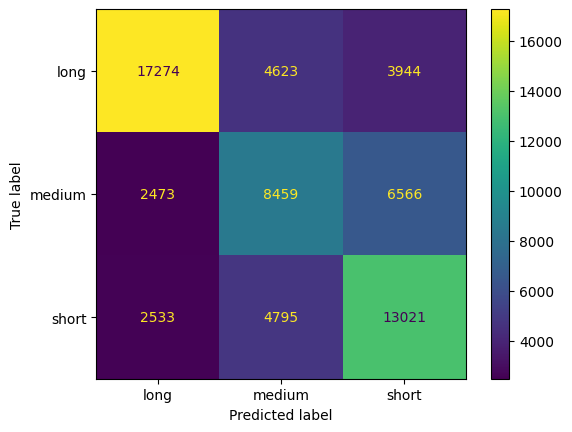

In [15]:
# Define XGBoost parameters
params = {
    "objective": "multi:softmax",    
    "num_class": 3,                  
    "eval_metric": "merror",         
    "learning_rate": 0.05,           
    "max_depth": 10,                
    "num_leaves": 64,              
    "lambda": 2.0,                 
    "alpha": 0.3,                 
    "subsample": 0.8,              
    "colsample_bytree": 0.8,         
    "scale_pos_weight": 1.0,         
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,  
    early_stopping_rounds=50,
    evals=[(dtest, 'eval')],  
)

y_pred = model.predict(dtest)
y_pred = np.round(y_pred).astype(int)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
model3_conf = confusion_matrix(y_test, y_pred)
conf3_display = ConfusionMatrixDisplay(confusion_matrix = model3_conf, display_labels=['long','medium','short'])
conf3_display.plot()

## Final Remarks:

Turns out the last model we trained was the best, with a final Accuracy of 60.85%. The correlation matrix is shown above. The final model is an XGBoost model with the following parameters:
- objective = multi:softmax    
- num_class = 3                  
- eval_metric = merror         
- learning_rate = 0.05           
- max_depth = 10                
- num_leaves = 64              
- lambda = 2.0                 
- alpha = 0.3                 
- subsample = 0.8              
- colsample_bytree = 0.8         
- scale_pos_weight = 1.0

Below are the relevant evaluation metrics of the model:

![img](8.png)